In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim import matutils
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import pickle
from pymongo import MongoClient
from bson import json_util

In [2]:
%matplotlib inline

# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

### JSON-Mongo Stuff

In [3]:
# json_address = 'https://www.kaggle.com/jayrav13/american-presidency-project/downloads/presidency.json/1'

In [4]:
# conn = MongoClient()

In [5]:
# conn.database_names()

In [6]:
# db = conn['president']

In [7]:
# data = json_util.dumps(json_file)

### Presidents List

In [8]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [9]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [10]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [197]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0, ignore_index=True)        

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58595 entries, 0 to 48
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.0+ MB


### Dataset Overview

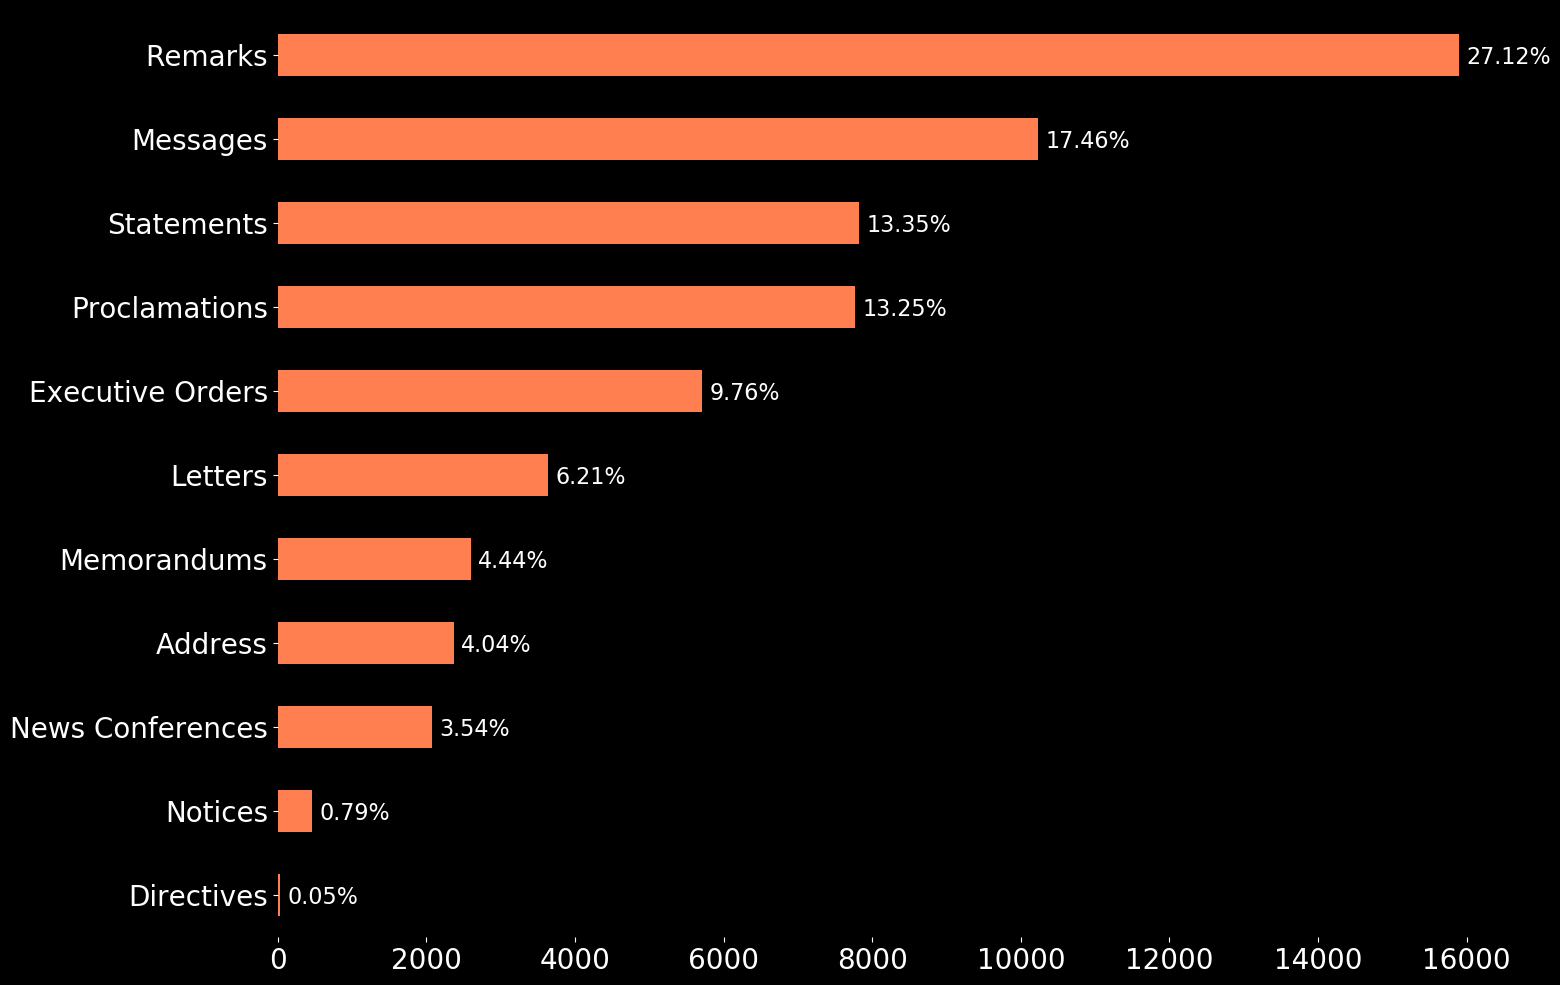

In [205]:
cats = df.category.value_counts(normalize=False, sort=True, ascending=True)
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16,12))
cats.plot(kind="barh", color='coral')
ax.set_frame_on(0)

# ax.set_title('Dataset Breakdown', fontdict={'fontsize': 20, 'fontweight': 'bold', 'fontstyle': 'italic'})
ax.tick_params(axis='both', labelsize=20)

# find the values and append to list
totals = []
for i in ax.patches:
    totals.append(i.get_width())
# set individual bar lables using above list
total = sum(totals)
# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+100, i.get_y()+.15,
            str(round((i.get_width()/total)*100, 2))+'%', 
            color='white', fontsize=16)

In [337]:
df[df.category=='Statements'].iloc[-10:, :]

President     Type    category  \
57238  William J. Clinton  Written  Statements   
57239  William J. Clinton  Written  Statements   
57240  William J. Clinton  Written  Statements   
57241  William J. Clinton  Written  Statements   
57242  William J. Clinton  Written  Statements   
57243  William J. Clinton  Written  Statements   
57244  William J. Clinton  Written  Statements   
57245  William J. Clinton  Written  Statements   
58543      Woodrow Wilson  Written  Statements   
58544      Woodrow Wilson  Written  Statements   

                                                 content document_date  \
57238  I am announcing today my decision to veto legi...    1995-08-11   
57239  Over the past 4 1/2 years, my administration h...    1997-10-14   
57240  I have used my line item veto authority today ...    1997-10-16   
57241  I have used my line item veto today to save ta...    1997-10-17   
57242  I have committed my administration to an uncea...    1998-06-23   
57243  H.R. 2587, the "District of Columbia Appropria...    1999-09-28   
57244  Today I vetoed a deeply flawed energy/water ap...    2000-10-07   
57245  I am returning herewith without my approval, H...    2000-10-30   
58543  I think that the public ought to know the extr...    1913-05-26   
58544  My Fellow Countrymen: The Congressional electi...    1918-10-25   

            pid        subcategory  \
57238   51733.0    Veto Statements   
57239   53407.0    Veto Statements   
57240   53415.0    Veto Statements   
57241   53420.0    Veto Statements   
57242   56195.0    Veto Statements   
57243   56603.0    Veto Statements   
57244    1219.0    Veto Statements   
57245    1082.0    Veto Statements   
58543  117309.0  (non categorized)   
58544  110491.0  (non categorized)   

                                                   title  
57238  Statement on Vetoing Legislation To Lift the A...  
57239  Statement on Line Item Vetoes of the Departmen...  
57240  Statement on a Line Item Veto of the Treasury ...  
57241  Statement on Line Item Vetoes of the Energy an...  
57242  Statement on Returning Without Approval to the...  
57243  Statement on Returning Without Approval to the...  
57244  Statement on Returning to the House of Represe...  
57245  Statement on Returning Without Approval to the...  
58543                    Statement on "The Tariff Lobby"  
58544  Statement Appealing to the Nation for Support ...

### Clean Corpus

In [13]:
corpus = df['content']

In [14]:
len(corpus)

58595

In [15]:
# clean and stem presidential addresses
clean_corpus = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")
# house_senate_opening = re.compile('''to\s+the\s+(?:senate|house\s+of\s+representatives|)
#                                      (\s+and\s+)*(?:senate|house\s+of\s+representatives|house)*''')
for doc in corpus:
    temp = doc.lower()
    temp = re.sub(r'\n', ' ', temp)
    temp = re.sub(r'united\s+states', ' ', temp)
    temp = re.sub(r'mr.\s+(vice)?president', ' ', temp)
    temp = re.sub(r'(?:mr\.|madam)\s+speaker', ' ', temp)
    temp = re.sub(r'americaa', 'america', temp)
    temp = re.sub(r'special\s+message', ' ', temp)
    temp = re.sub(r'executive\s+order', ' ', temp)
    temp = re.sub(r'statement\s+on\s+the', ' ', temp)
    temp = re.sub(r'section\s+\d+', ' ', temp)
#     temp = re.sub(house_senate_opening, temp)
    temp = re.sub(r'[^A-Za-z]+', ' ', temp)
    temp = re.sub(punctuation, ' ', temp)
    
#     temp = word_tokenize(temp)
#     lemma = []
#     for word in temp:
#         lemma.append(stemmer.stem(word))
#     temp = ' '.join(clean_corpus[0])
    
    clean_corpus.append(temp)
    
len(clean_corpus)

58595

### Topic Modeling

In [18]:
# Combine Sklearn and NLTK English stop words
months_list = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 
               'july', 'jul', 'august', 'aug', 'september', 'sept', 'october', 'oct', 'november', 'nov', 'december', 'dec']
custom_stopwords = ['hereunto', 'whereof', 'thereof', 'nineteen', 'said', 'herewith', 'shall', 'say', 'like',
                    'mr', 'mrs', 'sir', 'dear', 'george', 'bush', 'william', 'thirty', 'lot', 'want', 'let', 'clinton',
                    'sure', 'way', 'section', 'act', 'answer', 'laughter', 'great', 'good', 'things', 'thing',
                    'going', 'know', 'day', 'new', 'make', 'got', 'yes', 'year', 'week', 'sec', 'obama', 'john'] + months_list

stopwords = sklearn_stopwords.ENGLISH_STOP_WORDS \
            .union(nltk_stopwords.words('english')) \
            .union(gensim_stopwords) \
            .union(custom_stopwords)

In [19]:
n_features = 1000
n_topics = 20
n_top_words = 20
seed = 129

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                                   min_df=0.02,    
                                   max_df=0.8,
                                   stop_words=stopwords,
                                   max_features=n_features,
                                   token_pattern=r'\b[a-zA-Z]{3,}\b')

tfidf = tfidf_vectorizer.fit_transform(clean_corpus)
tfidf.shape

(58595, 1000)

In [324]:
svd = TruncatedSVD(n_components=999, random_state=seed)
svd.fit(tfidf)
p = svd.fit_transform(tfidf)

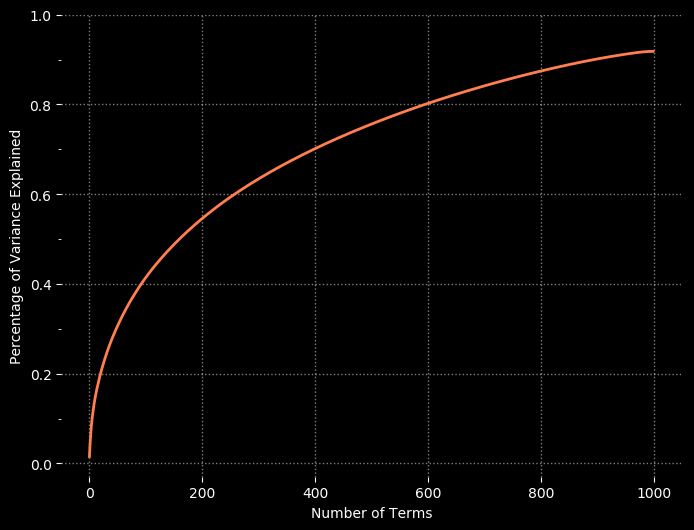

In [331]:
# plt.style.use('default')
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(p.shape[1]), np.cumsum(svd.explained_variance_), linewidth=2, color='coral')
# ax.axhline(0.75, ls='--', c='k')
ax.grid(linestyle=':', linewidth=1, alpha=0.5)
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_yticks(np.arange(0, 1.2, 0.2), minor=False)
# ax.grid(which='minor', alpha=0.4)
# ax.grid(which='major', alpha=0.8)
ax.set_frame_on(0)
ax.set_xlabel('Number of Terms')
ax.set_ylabel('Percentage of Variance Explained');

In [23]:
nmf = NMF(n_components=n_topics, random_state=seed, alpha=0.1, l1_ratio=0.2, 
          init='nndsvd', verbose=True)
reduced = nmf.fit_transform(tfidf)
print(reduced.shape)

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.2,
  max_iter=200, n_components=20, random_state=129, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [27]:
# pickle TF-IDF NMF results
pickle_file = 'APP_tfidf_nmf_results.pickle'
data = {'tfidf_vectorizer': tfidf_vectorizer, 
        'tfidf': tfidf,
        'nmf': nmf,
        'reduced': reduced}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [274]:
from sklearn.preprocessing import normalize
normalized = normalize(tfidf, norm='l1', axis=0)

In [290]:
avg = list(np.mean(tfidf, axis=0))


In [302]:
pd.DataFrame([tfidf_feature_names, avg])

0
0  [ability, able, abroad, access, accordance, ac...
1  [[[[[ 0.00463419  0.00878112  0.00449951  0.00...

In [315]:
names = np.reshape(tfidf_feature_names, (1000, 1))
names.shape

(1000, 1)

In [316]:
vals = np.reshape(avg, (1000, 1))
vals.shape

(1000, 1)

In [323]:
[x[0], x[1] for x in list(np.concatenate([names, vals], axis=1))]

SyntaxError: invalid syntax (<ipython-input-323-5f41c7682036>, line 1)

In [317]:
pd.DataFrame([names, vals])

ValueError: Must pass 2-d input

In [303]:
temp = list(zip(np.reshape(tfidf_feature_names, 1, -1, avg))

In [277]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [295]:
temp = list(zip(tfidf_feature_names, avg))
term_dict = dict(sorted(temp, key=lambda x: x[1], reverse=True)[:1000])

In [296]:
term_dict

{'ability': matrix([[ 0.00463419,  0.00878112,  0.00449951,  0.0043538 ,  0.0084002 ,
           0.00317042,  0.00517547,  0.01281992,  0.00696199,  0.01004668,
           0.0034618 ,  0.00328491,  0.00538949,  0.00710091,  0.00434407,
           0.00307798,  0.0156491 ,  0.00332346,  0.00397021,  0.0039789 ,
           0.00557633,  0.00539932,  0.00280747,  0.00390062,  0.00459507,
           0.00499435,  0.01216766,  0.00976163,  0.01136393,  0.00356763,
           0.00403789,  0.01437322,  0.00472853,  0.00409219,  0.00655821,
           0.00545414,  0.00560848,  0.00695133,  0.00441656,  0.00358616,
           0.01599323,  0.00444879,  0.04648907,  0.00906455,  0.03285175,
           0.01098828,  0.0245527 ,  0.00558258,  0.00309995,  0.0064982 ,
           0.00330512,  0.01147259,  0.00602473,  0.00493129,  0.00822417,
           0.00739753,  0.00758243,  0.00656486,  0.00512161,  0.00550859,
           0.00675254,  0.00348407,  0.00756326,  0.00589413,  0.00295406,
           0.0

In [292]:
term_dicts = []
component_lists = []
for index,values in enumerate(tfidf_feature_names):
#     print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, avg[index]))
#     print(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words], "\n")
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:1000]))
#     component_lists.append(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words])

IndexError: list index out of range

In [29]:
# Helper Function to pull out top words associated with topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [30]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
people thank country years america world come today work american time think proud right life god man hope tonight nation 

Topic #1:
war service veterans men military forces women armed army armed forces general men women navy nation defense honor peace vietnam duty americans 

Topic #2:
america president america proclamation president independence set hand america proclamation witness set independence america witness lord hand americans set proclaim nation national appropriate american joint 

Topic #3:
senate transmit treaty convention resolution consideration state report advice secretary state secretary signed view information letter republic constitutional government recommend department 

Topic #4:
nations world peace united united nations freedom international soviet countries human rights europe free people peoples nuclear economic human rights cooperation american 

Topic #5:
president think question time general press believe tell committee situation course stateme

In [59]:
component_dicts = []
component_lists = []
components = nmf.components_
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tfidf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words], "\n")
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words]))
    component_lists.append(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words])

topic 0
[('people', 4.5903776769562183), ('thank', 3.0805761717453293), ('country', 2.4918988971126237), ('years', 1.572705841080319), ('america', 1.5357985999740118), ('world', 1.3485766648574733), ('come', 1.2983133839326171), ('today', 1.2958190103052656), ('work', 1.2563052441047271), ('american', 1.2323028521543327), ('time', 1.1203111648790531), ('think', 1.1139198833968844), ('proud', 0.95849740404456085), ('right', 0.94627456522713582), ('life', 0.92445514993282074), ('god', 0.91782254099822391), ('man', 0.87362739002846035), ('hope', 0.84473172653604089), ('tonight', 0.83598049690832621), ('nation', 0.82445015610476236)] 

topic 1
[('war', 3.3918055403867928), ('service', 2.5584666869190524), ('veterans', 2.3276971563238709), ('men', 1.9624183625239437), ('military', 1.9036566781497186), ('forces', 1.6718993102925899), ('women', 1.5568312082748983), ('armed', 1.3180946909835367), ('army', 1.2136601738154571), ('armed forces', 1.1816734038837502), ('general', 1.1741101074213269

### Topic Breakdown

In [101]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = list(colors[1])

In [218]:
topic_list = ['American People',
              'Military',
              'American Independence',
              'Congress (Senate)',
              'World Peace',
              'Press Conferences',
              'Congress (House)',
              'National Emergency',
              'Trade',
              'Authority',
              'Secretary of State',
              'Labor/Jobs',
              'Health Care',
              'Expansion',
              'Taxes/Economy',
              'Government Assistance',
              'Congress (Committees)',
              'Foreign Relations',
              'Terrorism',
              'Education']

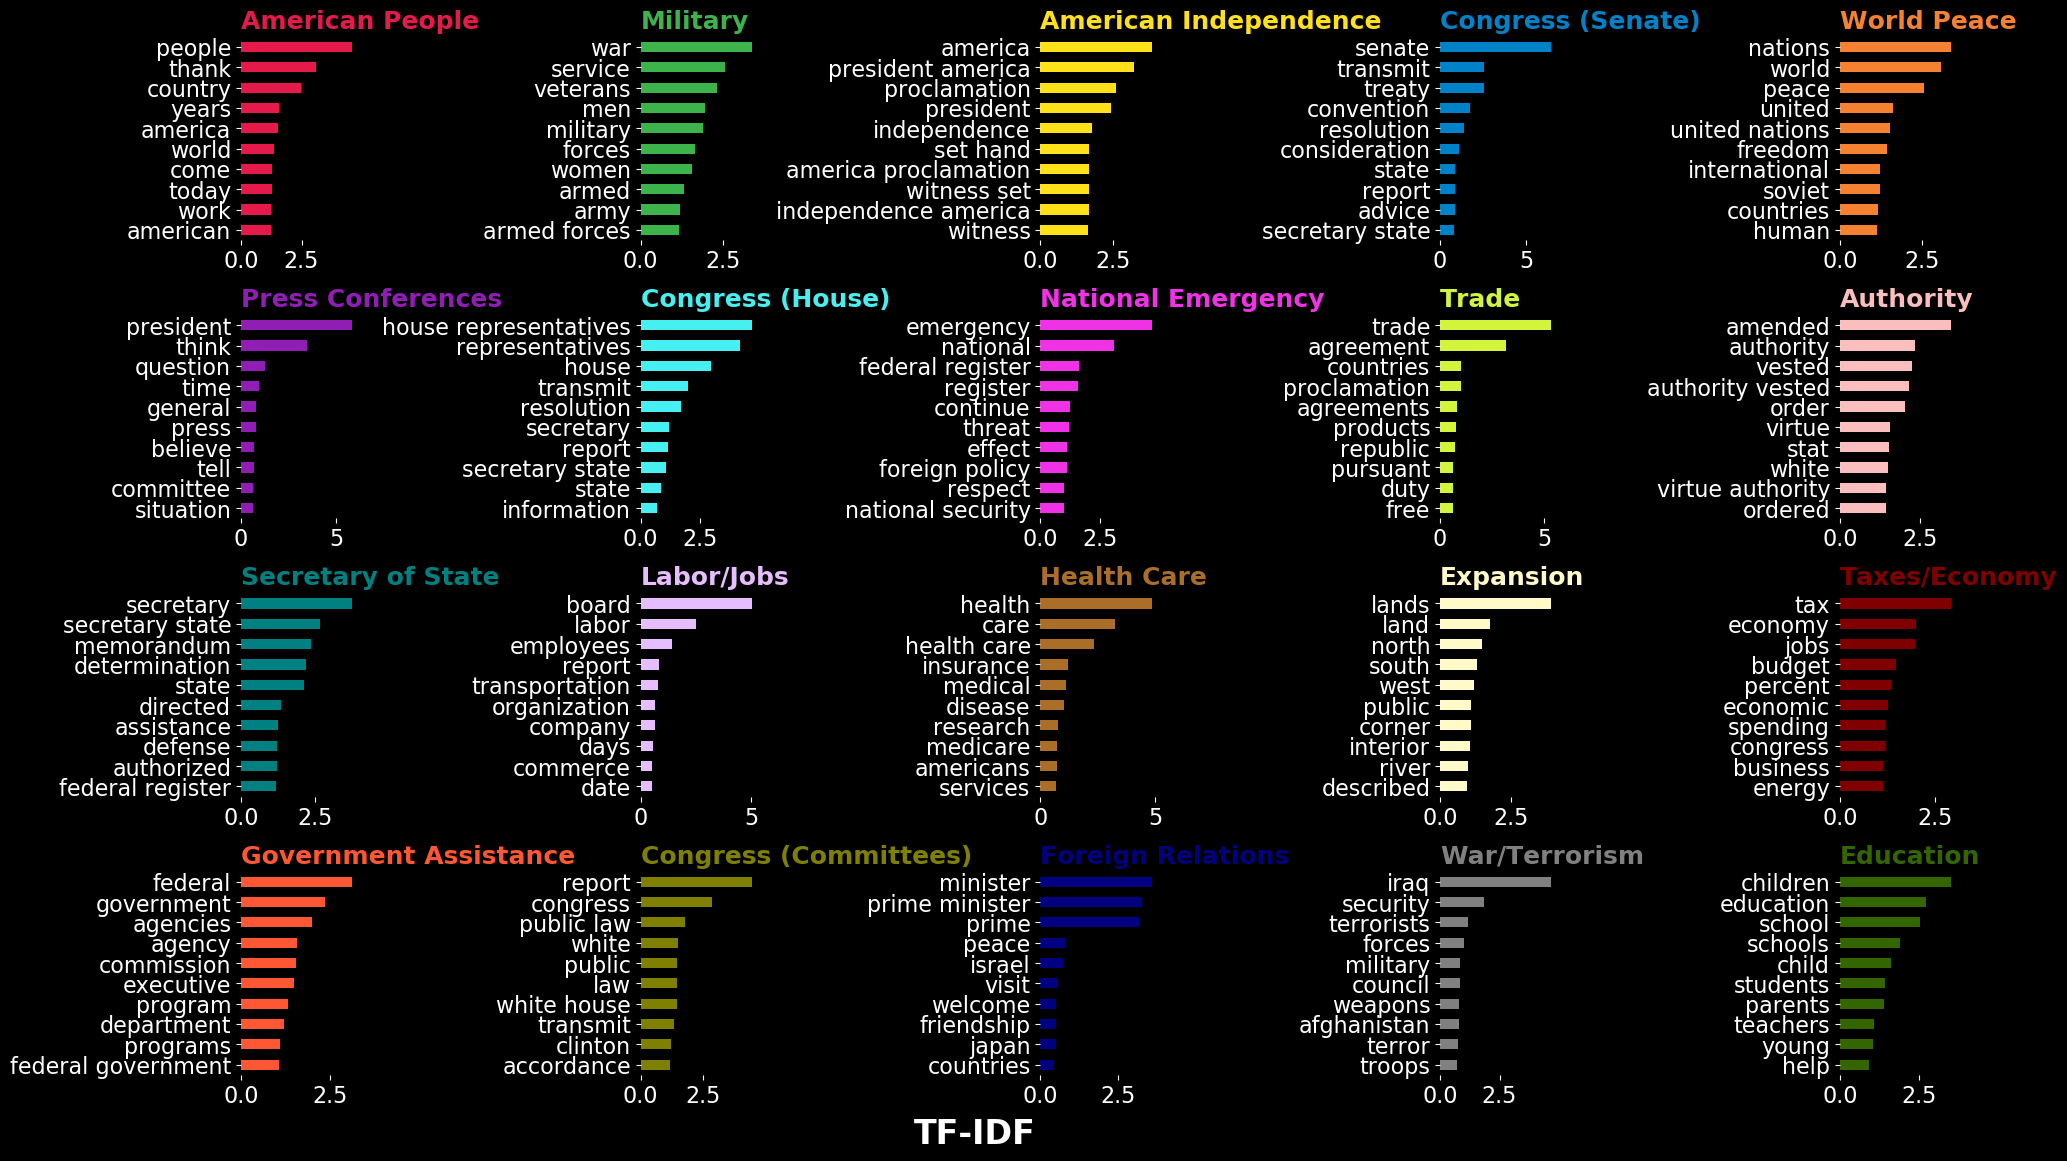

In [219]:
plt.style.use('dark_background')
fig, ax = plt.subplots(4, 5, figsize=(20, 12))
for num, topic in enumerate(component_lists):

    # Get subplot axes
    ax = plt.subplot(4, 5, num+1)

    topic = topic[:10]
    tmp_df = pd.DataFrame(topic).sort_values([1])    
    tmp_df.plot.barh(color=cmap[num], legend=False, ax=ax)
    ax.set_yticklabels(tmp_df[0])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_frame_on(0)
    
#     ax.set_xlim(0, 5)    
#     ax.set_xticks(np.arange(0, 5))
#     ax.set_xticks([])
#     if num < 15:        
#         ax.set_xticklabels([])
        
#     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    plt.title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])

fig.text(0.5, 0, 'TF-IDF', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

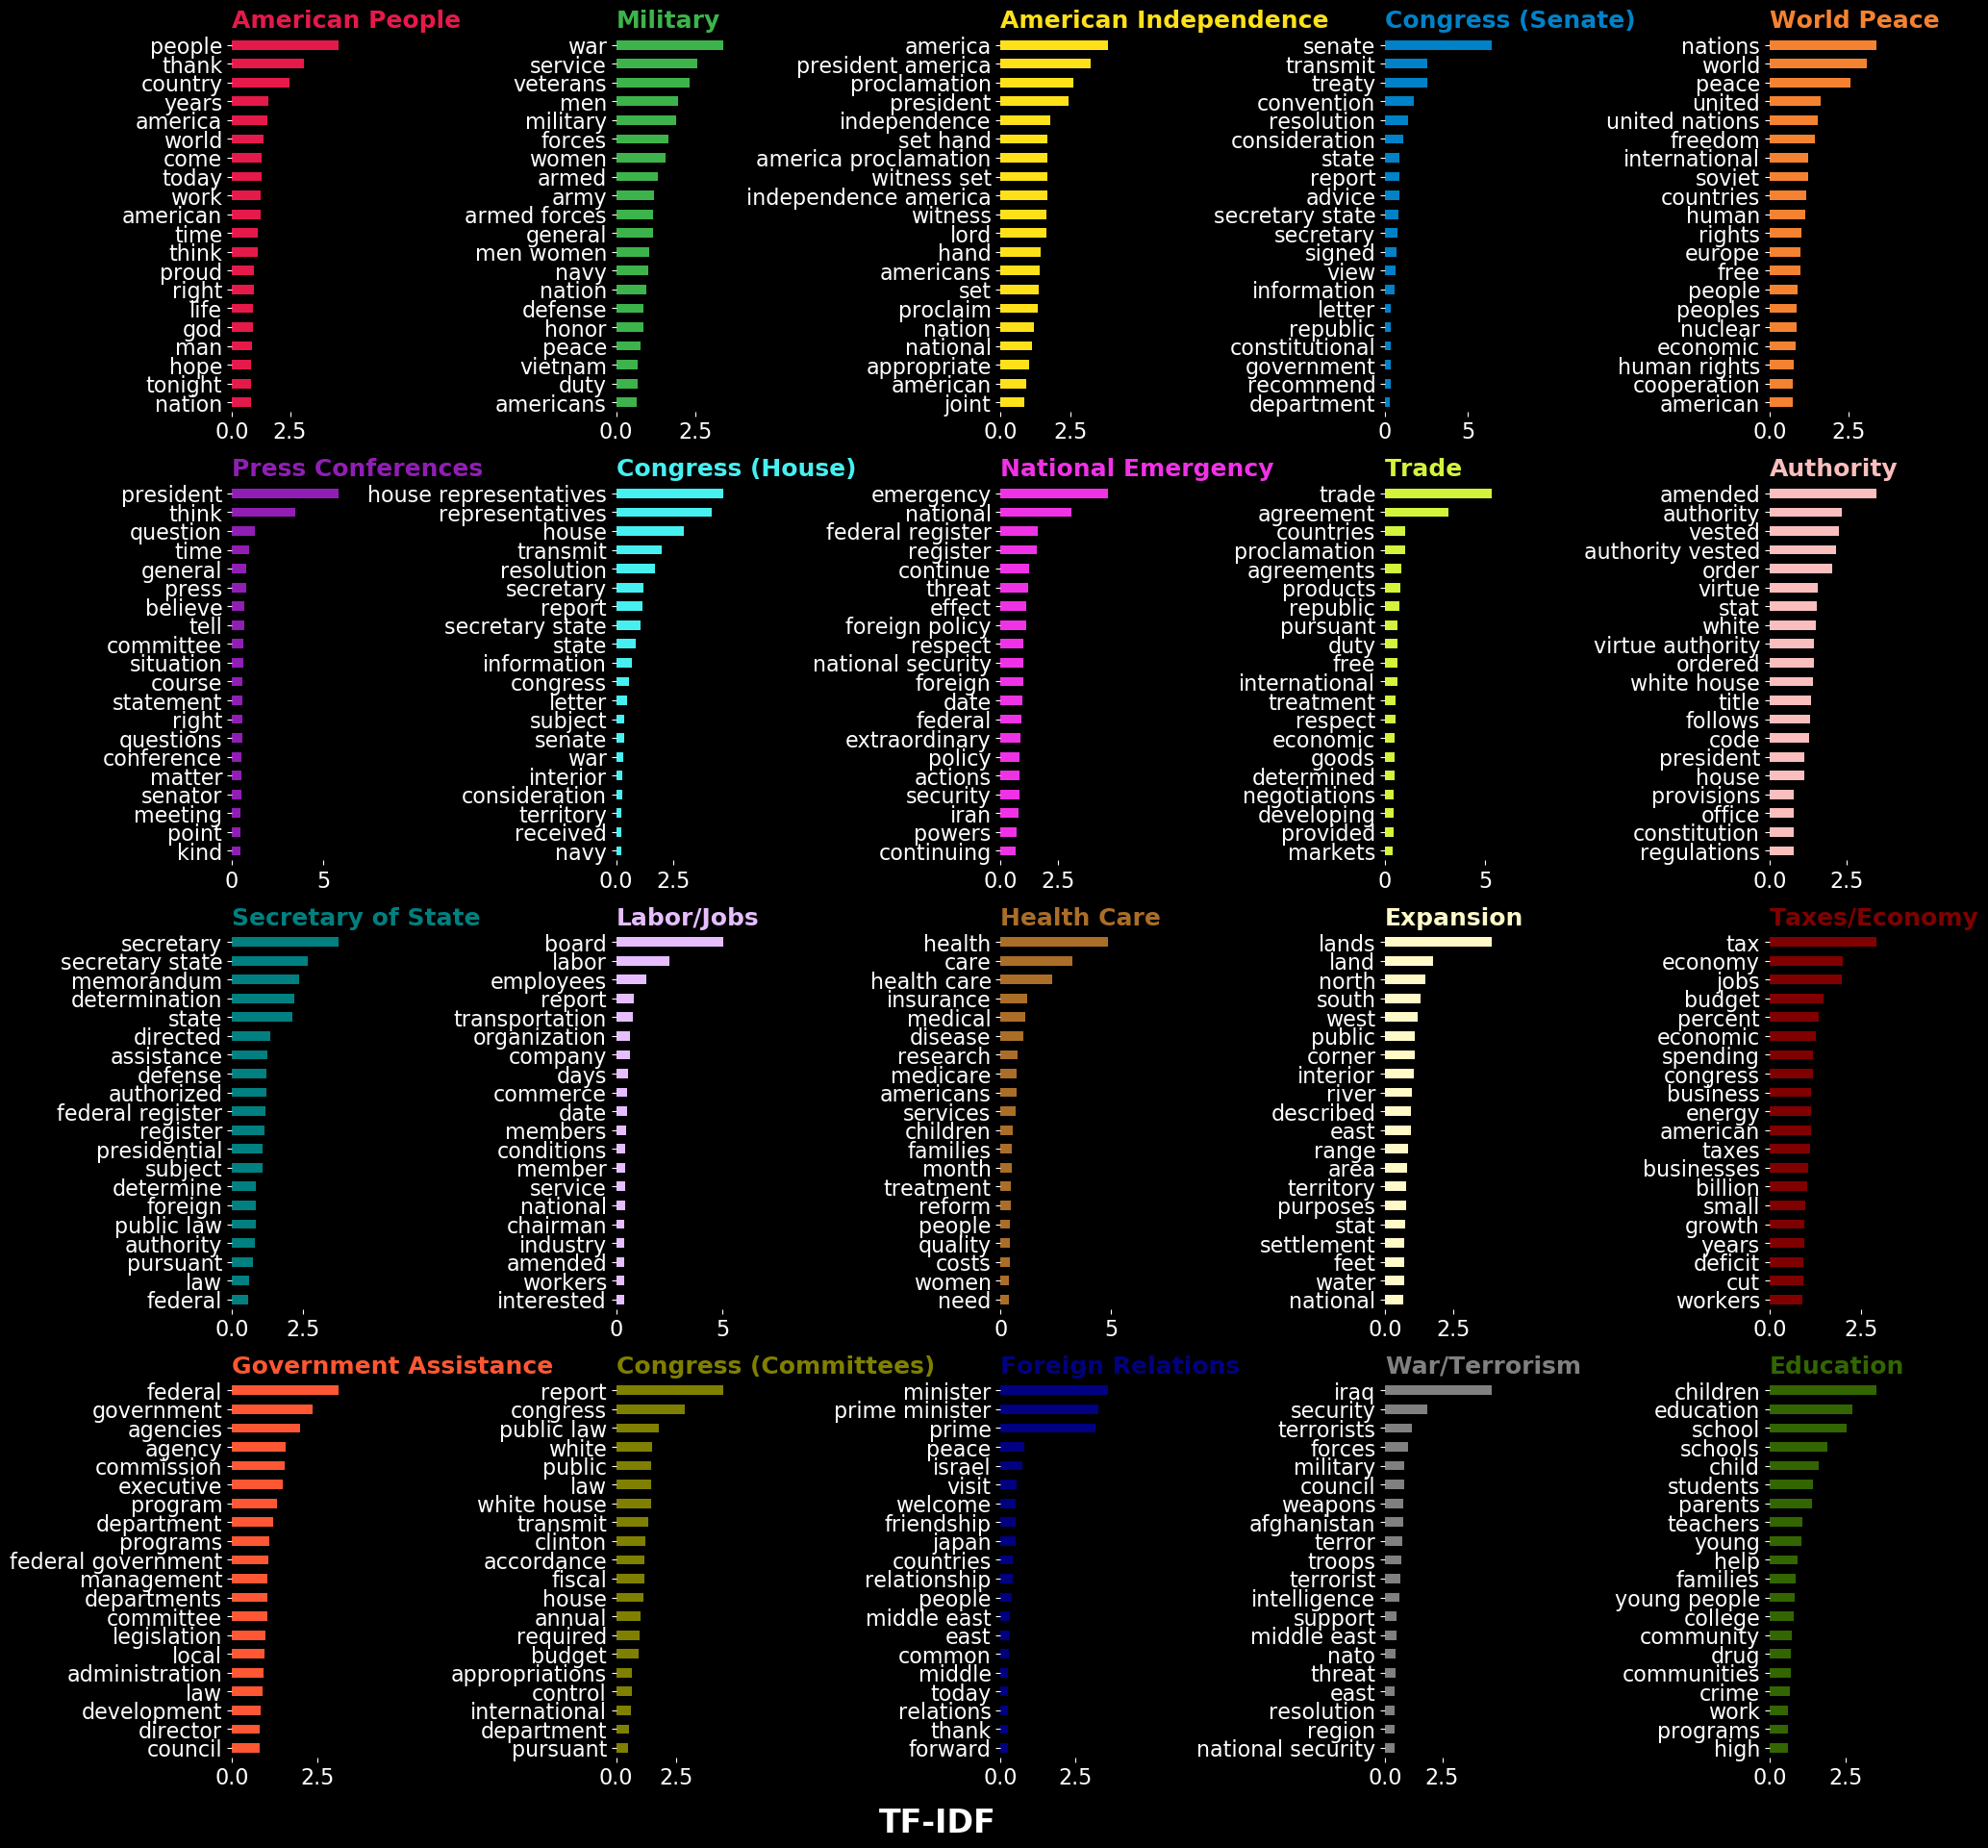

In [223]:
plt.style.use('dark_background')
fig, ax = plt.subplots(4, 5, figsize=(20, 20))
for num, topic in enumerate(component_lists):

    # Get subplot axes
    ax = plt.subplot(4, 5, num+1)

#     topic = topic[:10]
    tmp_df = pd.DataFrame(topic).sort_values([1])    
    tmp_df.plot.barh(color=cmap[num], legend=False, ax=ax)
    ax.set_yticklabels(tmp_df[0])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_frame_on(0)
    
#     ax.set_xlim(0, 5)    
#     ax.set_xticks(np.arange(0, 5))
#     ax.set_xticks([])
#     if num < 15:        
#         ax.set_xticklabels([])
        
#     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    plt.title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])

fig.text(0.5, 0, 'TF-IDF', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

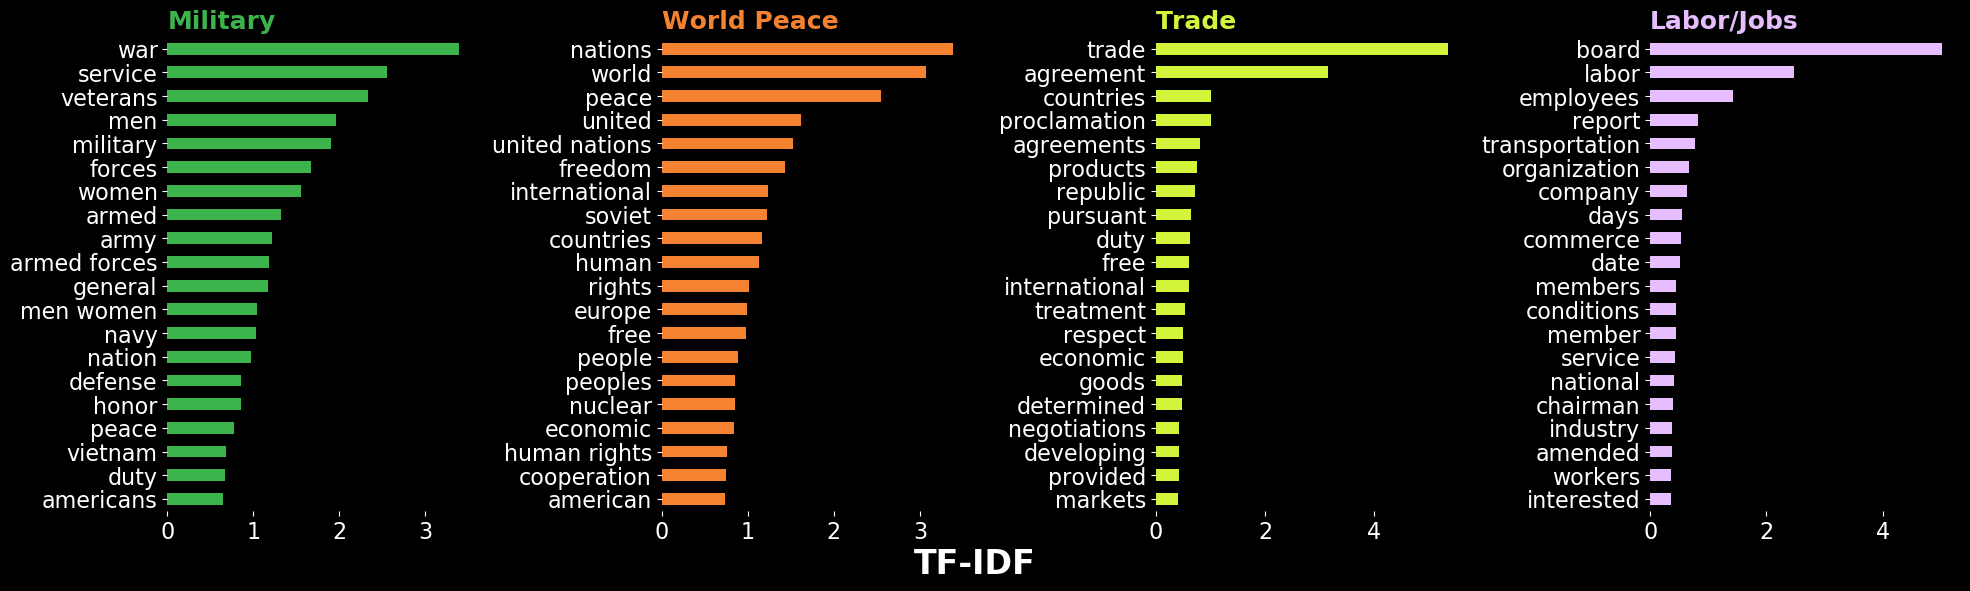

In [233]:
plt.style.use('dark_background')
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
# for num, topic in enumerate(component_lists):
ax_num = 0
for num in [1, 4, 8, 11]:  
    ax_num += 1
    topic = component_lists[num]

    # Get subplot axes
    ax = plt.subplot(1, 4, ax_num)

#     topic = topic[:10]
    tmp_df = pd.DataFrame(topic).sort_values([1])    
    tmp_df.plot.barh(color=cmap[num], legend=False, ax=ax)
    ax.set_yticklabels(tmp_df[0])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_frame_on(0)
    
#     ax.set_xlim(0, 5)    
#     ax.set_xticks(np.arange(0, 5))
#     ax.set_xticks([])
#     if num < 15:        
#         ax.set_xticklabels([])
        
#     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    plt.title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])

fig.text(0.5, 0, 'TF-IDF', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

### Normalize Topics by Year

In [186]:
tm_df = pd.DataFrame(reduced)

In [200]:
tm_df['year'] = df.document_date.dt.year

In [201]:
# Normalize topic frequency by year
topic_freq = tm_df.groupby('year').sum()
topic_freq = 100 * topic_freq.div(topic_freq.sum(axis=1), axis=0)
topic_freq = topic_freq.round(3)

In [202]:
topic_freq.sample(10, random_state=129)

0       1       2       3       4       5       6       7      8   \
year                                                                          
1873   1.679   7.552   7.167  16.071   1.458   6.335  17.657   1.280  2.116   
1960  11.405   5.421   8.578   1.118  15.214   7.952   1.449   1.712  3.758   
2015  11.338   4.937   8.304   0.428   5.244   3.895   0.497  10.913  3.799   
1830   1.053   6.029   1.462  28.257   1.352   4.303  28.944   0.705  1.996   
1968  11.636   6.794   6.857   2.181   8.470   7.132   1.283   1.561  2.959   
1938   9.663   5.402   1.534   1.610   5.175  10.930   2.975   3.354  2.086   
1983   9.194   4.457  10.932   2.293  10.188   5.189   1.232   2.868  5.024   
1924  15.930  10.903   9.074   0.355  10.102   2.211   0.898   2.435  1.949   
1915  11.751  12.963   8.338   0.834   9.018   4.192   2.020   1.616  3.810   
2016  10.838   5.008   8.378   0.478   5.300   4.306   0.391  11.514  3.187   

         9      10     11     12      13     14      15     16     17     18  \
year                                                                           
1873  4.329  8.667  2.334  0.654   5.204  1.399  10.120  4.634  0.884  0.397   
1960  6.413  3.577  6.014  1.623   4.189  3.744   8.908  2.188  3.707  0.997   
2015  4.064  5.223  1.618  7.508   2.038  7.647   4.194  2.191  2.535  5.093   
1830  0.708  2.924  0.733  0.032   8.200  0.414   4.191  6.275  1.852  0.336   
1968  5.336  3.134  3.116  4.383   3.496  6.094   8.970  4.663  4.373  0.975   
1938  8.246  2.433  6.595  1.785  13.653  6.671  10.948  3.694  0.772  0.252   
1983  5.313  2.163  2.143  3.460   1.912  8.679   7.728  4.093  5.049  2.526   
1924  2.806  1.674  1.344  0.949  18.452  4.198   9.805  2.011  0.429  0.110   
1915  6.901  3.356  2.161  0.305  24.961  1.774   3.001  2.041  0.373  0.127   
2016  5.364  5.887  1.047  7.846   2.705  5.224   5.989  2.166  2.307  5.132   

         19  
year         
1873  0.063  
1960  2.033  
2015  8.532  
1830  0.235  
1968  6.585  
1938  2.222  
1983  5.559  
1924  4.366  
1915  0.457  
2016  6.933

### Create Small Multiples of Topic Distributions Over Time

In [ ]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = list(colors[1])

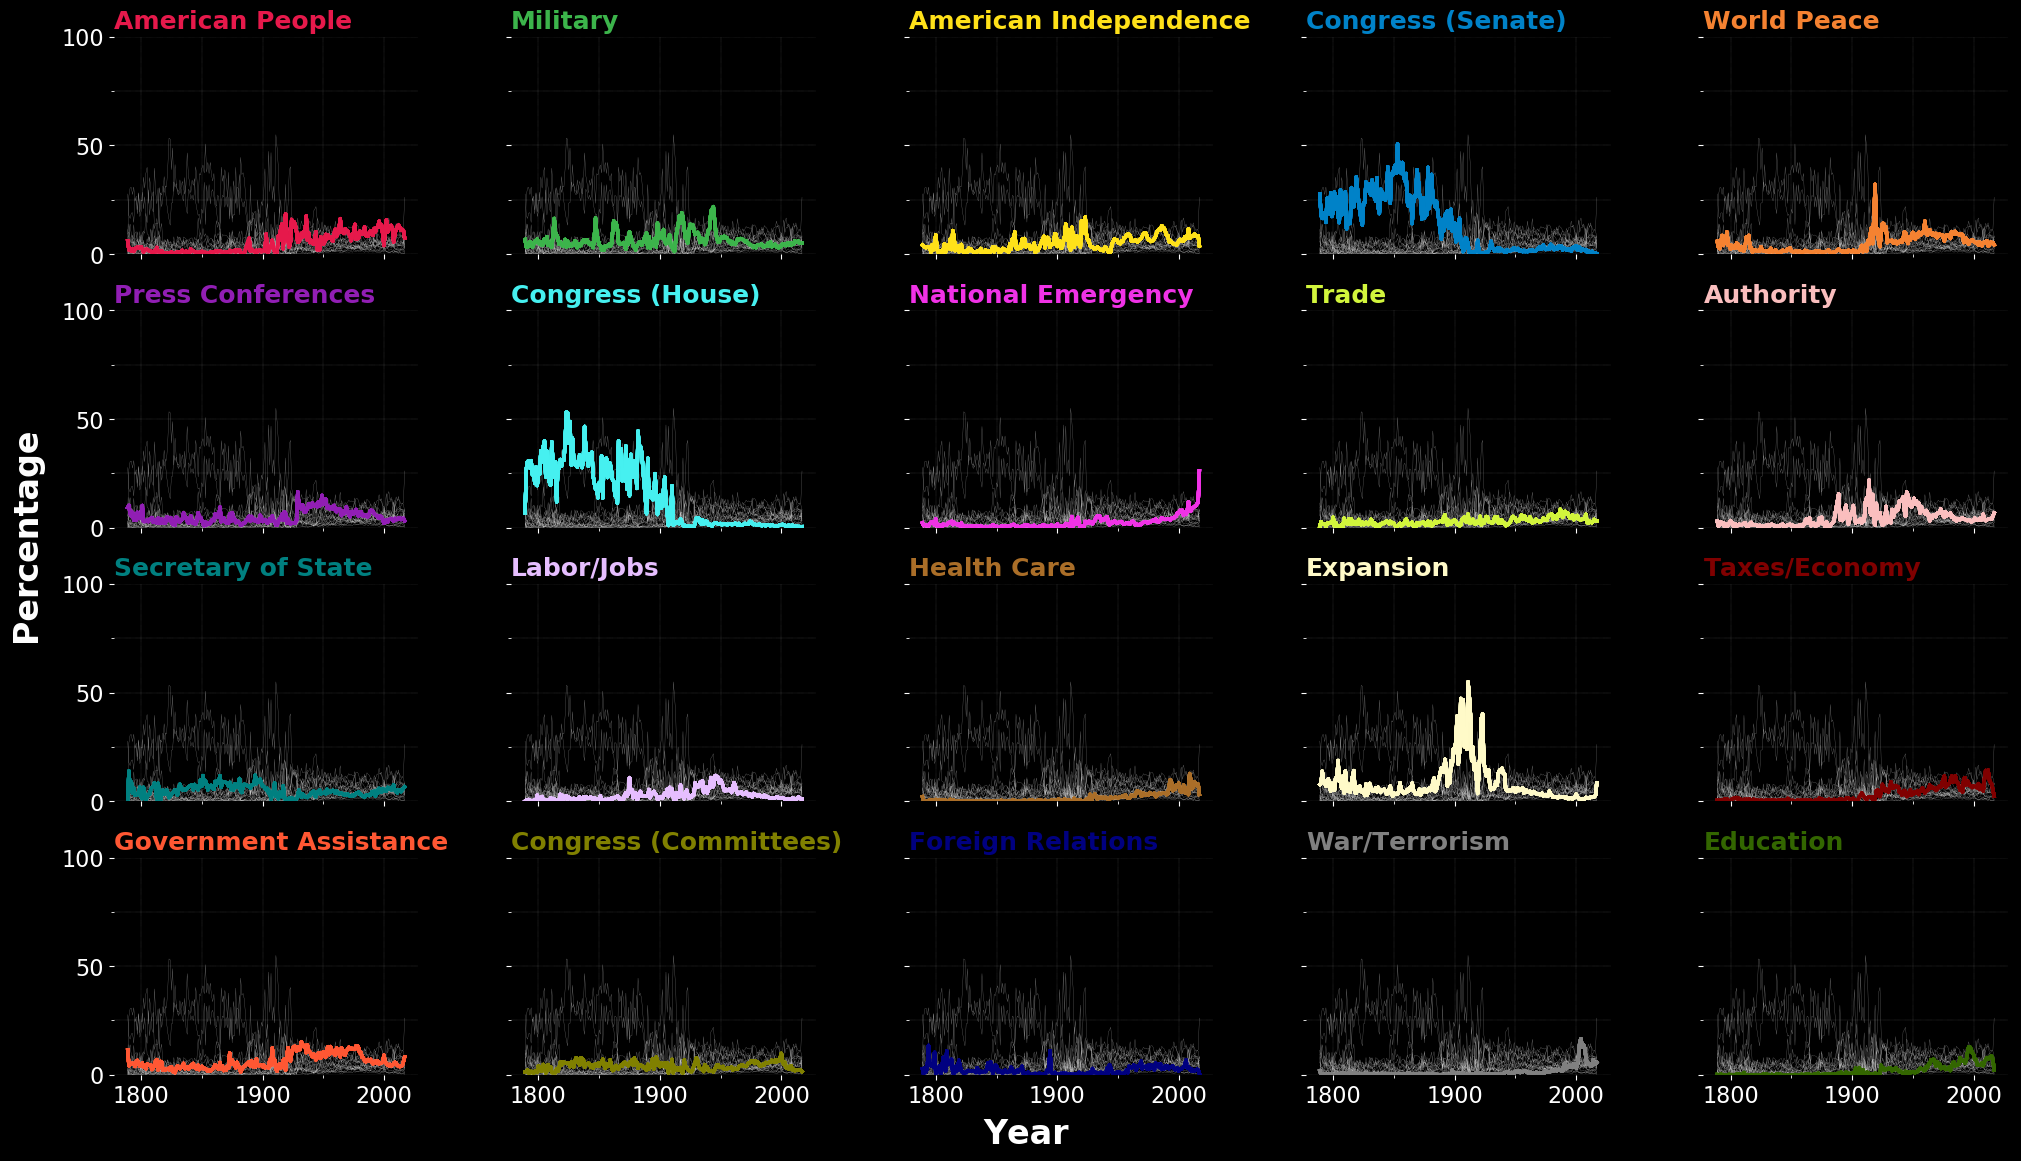

In [220]:
# plt.style.use('seaborn-darkgrid')
plt.style.use('dark_background')

# Initialize the figure
fig, axes = plt.subplots(4, 5, figsize=(20,12))
for num, col in enumerate(topic_freq.columns):   
    # Get subplot axes
    ax = plt.subplot(4, 5, num+1)
    
    for col2 in topic_freq.columns:
        # plot every topic in background
        plt.plot(topic_freq.index, topic_freq[col2], 
                 marker='', color='white', linewidth=0.2, alpha=0.5)
        # highlight plot
        plt.plot(topic_freq.index, topic_freq[col], 
                 marker='', color=cmap[num], linewidth=2.4, alpha=1, label=col)
    
    # Set axes properties
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xticks([1850, 1950], minor=True)
    ax.set_xticks([1800, 1900, 2000], minor=False)
    ax.set_yticks([25, 75], minor=True)
    ax.set_yticks([0, 50, 100], minor=False)       
    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.grid(which='major', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.set_frame_on(0)
    
    ax.set_ylim(0, 100)    
    if num < 15:
        plt.tick_params(labelbottom='off')
    if num not in np.arange(0, 20, 5):
        plt.tick_params(labelleft='off')
    # Add title
#     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    plt.title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    
# general title and axis labels
# fig.suptitle('Topic Density Over Time', fontsize=36, fontweight='bold')
fig.text(0, 0.5, 'Percentage', 
         ha='center', va='center', rotation='vertical', 
         fontdict={'fontsize':24, 'fontweight':'bold'})
fig.text(0.5, 0, 'Year', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

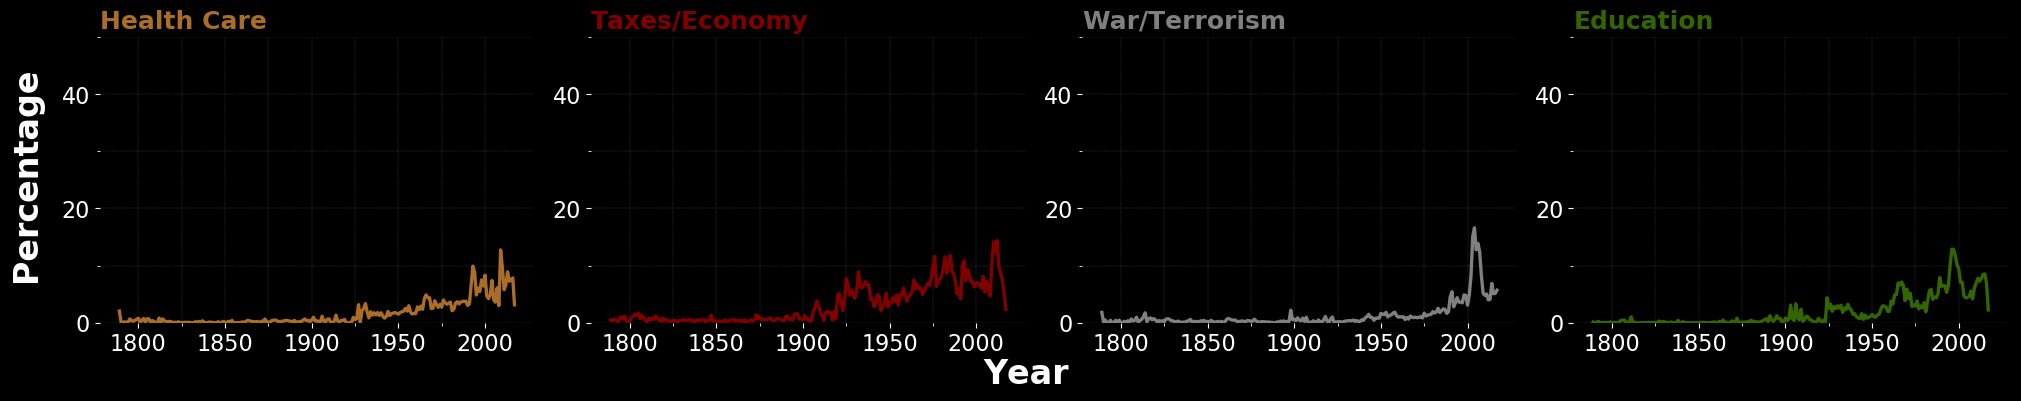

In [253]:
# plt.style.use('seaborn-darkgrid')
plt.style.use('dark_background')

# Initialize the figure
fig, axes = plt.subplots(1, 4, figsize=(20,4))

# for num, topic in enumerate(component_lists):
ax_num = 0
# for num in [1, 4, 8, 11]: 
for num in [12, 14, 18, 19]: 
    ax_num += 1

    # Get subplot axes
    ax = plt.subplot(1, 4, ax_num)
    
    plt.plot(topic_freq.index, topic_freq[num], 
             marker='', color=cmap[num], linewidth=2.4, alpha=1, label=num)
    
# for num, col in enumerate(topic_freq.columns[[1, 4, 8, 11]]):   

#     # Get subplot axes
#     ax = plt.subplot(1, 4, num+1)
    
#     for col2 in topic_freq.columns:
# #         # plot every topic in background
# #         plt.plot(topic_freq.index, topic_freq[col2], 
# #                  marker='', color='white', linewidth=0.2, alpha=0.5)
#         # highlight plot
#         plt.plot(topic_freq.index, topic_freq[col], 
#                  marker='', color=cmap[num], linewidth=2.4, alpha=1, label=col)
    
    # Set axes properties
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xticks([1825, 1875, 1925, 1975], minor=True)
    ax.set_xticks([1800, 1850, 1900, 1950, 2000], minor=False)
    ax.set_yticks([10, 30, 50, 70, 90], minor=True)
    ax.set_yticks([0, 20, 40, 60, 80, 100], minor=False)          
    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.grid(which='major', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.set_frame_on(0)    
    ax.set_ylim(0, 50)
    
#     if num < 15:
#         plt.tick_params(labelbottom='off')
#     if num not in np.arange(0, 20, 5):
#         plt.tick_params(labelleft='off')
    # Add title
#     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    ax.set_title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    
# general title and axis labels
# fig.suptitle('Topic Density Over Time', fontsize=36, fontweight='bold')
fig.text(0, 0.5, 'Percentage', 
         ha='center', va='center', rotation='vertical', 
         fontdict={'fontsize':24, 'fontweight':'bold'})
fig.text(0.5, 0, 'Year', ha='center', va='center', 
         fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

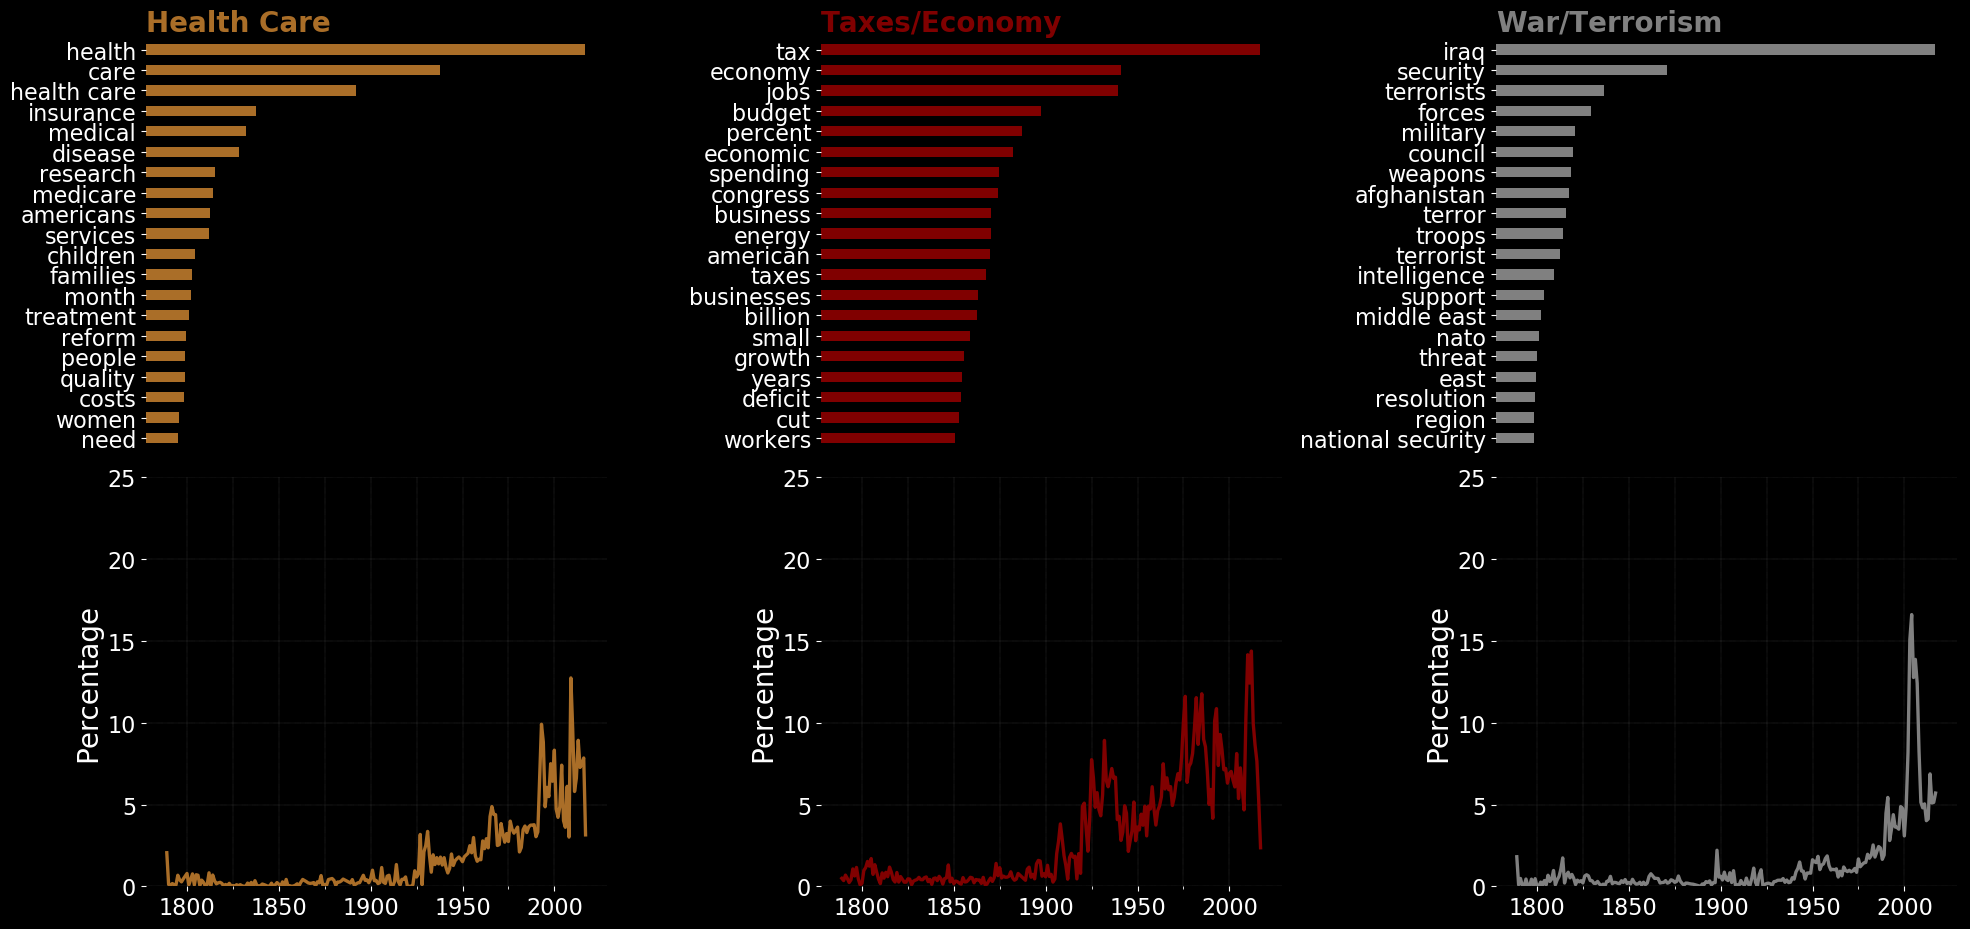

In [272]:
plt.style.use('dark_background')

# Initialize the figure
fig, axes = plt.subplots(2, 3, figsize=(20,10))

ax_num = 0
# for num in [1, 4, 8, 11]:  
for num in [12, 14, 18]:
    ax_num += 1
    topic = component_lists[num]

    # Get subplot axes
    ax = plt.subplot(2, 3, ax_num)

    tmp_df = pd.DataFrame(topic).sort_values([1])    
    tmp_df.plot.barh(color=cmap[num], legend=False, ax=ax)
    ax.set_yticklabels(tmp_df[0])
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xticks([])
    ax.set_frame_on(0)
    ax.set_title(topic_list[num], loc='left', fontsize=20, fontweight='bold', color=cmap[num])
    
    ##### Topic Timeline
    # Get subplot axes
    ax = plt.subplot(2, 3, ax_num+3)
    
    plt.plot(topic_freq.index, topic_freq[num], 
             marker='', color=cmap[num], linewidth=2.4, alpha=1, label=num)
    
    # Set axes properties
    ax.tick_params(axis='both', labelsize=16)
    
#     ax.set_xticks([1825, 1875, 1925, 1975], minor=True)
#     ax.set_xticks([1800, 1850, 1900, 1950, 2000], minor=False)
    ax.set_xticks([1825, 1875, 1925, 1975], minor=True)
    ax.set_xticks([1800, 1850, 1900, 1950, 2000], minor=False)
    
    ax.set_ylabel('Percentage', fontsize=20)    
#     ax.set_yticks([10, 30, 50, 70, 90], minor=True)
#     ax.set_yticks([0, 20, 40, 60, 80, 100], minor=False)     
#     ax.set_yticks([5, 15, 25, 35, 45], minor=True)
    ax.set_yticks([0, 5, 10, 15, 20, 25], minor=False)  
    ax.set_ylim(0, 25)
    
    ax.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.grid(which='major', linestyle=':', linewidth=0.3, alpha=0.5)
    ax.set_frame_on(0)    
    
    
#     if num < 15:
#         plt.tick_params(labelbottom='off')
#     if num not in np.arange(0, 20, 5):
#         plt.tick_params(labelleft='off')
#     # Add title
# #     plt.title('Topic #%d' % num, loc='left', fontsize=18, fontweight='bold', color=cmap[num])
#     plt.title(topic_list[num], loc='left', fontsize=18, fontweight='bold', color=cmap[num])
    
# # general title and axis labels
# # fig.suptitle('Topic Density Over Time', fontsize=36, fontweight='bold')
# fig.text(0, 0.5, 'Percentage', 
#          ha='center', va='center', rotation='vertical', 
#          fontdict={'fontsize':24, 'fontweight':'bold'})
# fig.text(0.5, 0, 'Year', ha='center', va='center', 
#          fontdict={'fontsize':24, 'fontweight':'bold'})

fig.tight_layout(rect=(0.01, 0.01, 1, 0.95))

### Create Word Clouds

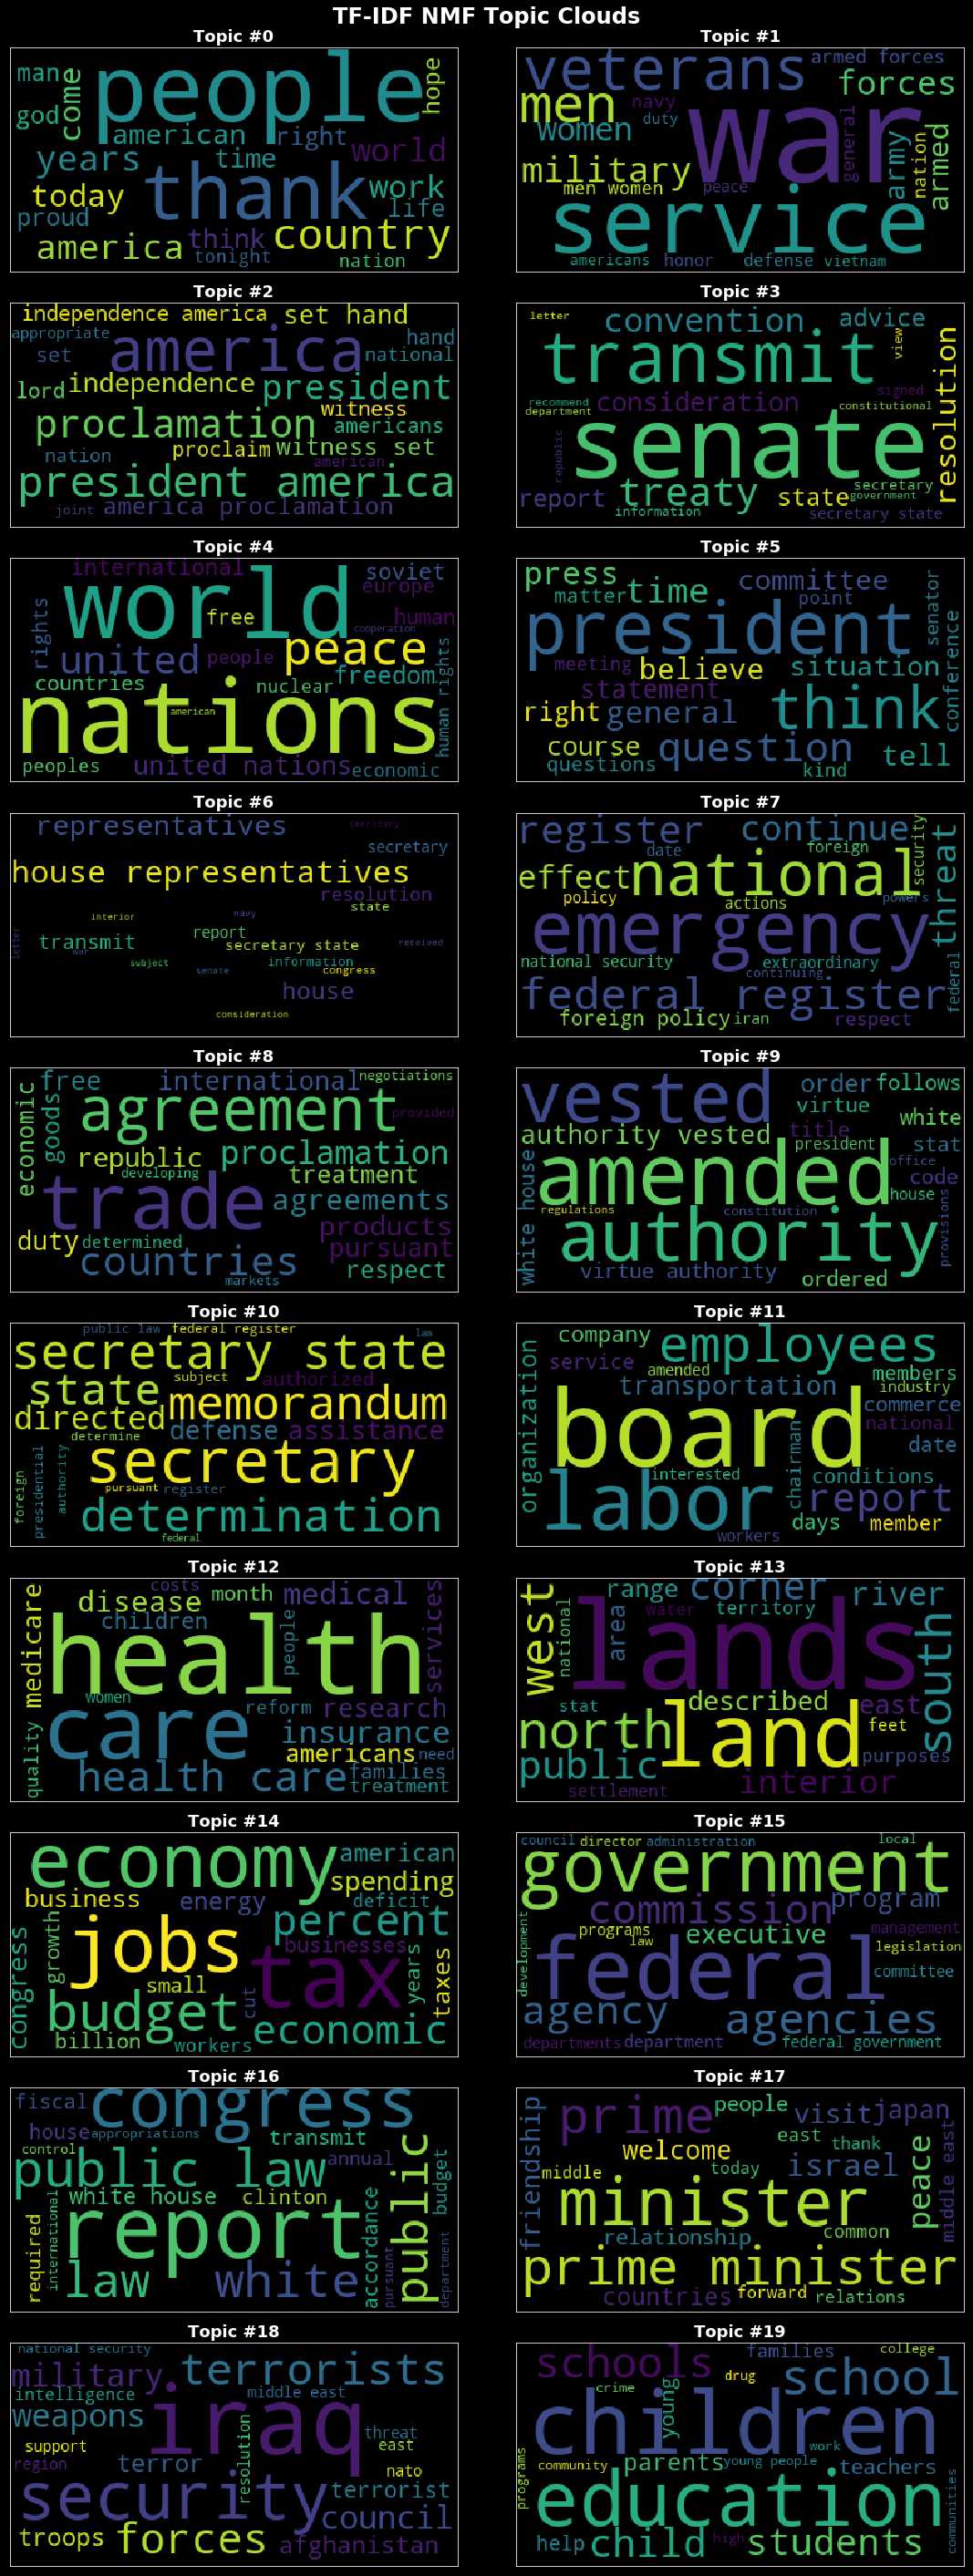

In [111]:
# Create topic word clouds
plt.style.use('dark_background')

ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 8
figheight = nrow * 4
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
#     plt.sca(ax[t])  
    curr_ax = fig.sca(ax[t])
    curr_ax.set_title('Topic #%d' % t, fontsize=18, fontweight='bold')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
#     curr_ax.set_axis_on(0)    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))
    
fig.tight_layout(rect=(0, 0, 1, 0.975))
fig.suptitle('TF-IDF NMF Topic Clouds', fontsize=24, fontweight='bold');

### Check Clustering Metrics

In [112]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
inertias = []
silhouettes = []
n_clusters = np.arange(2, 52, 2)
for n in tnrange(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[n], init="k-means++", random_state=129)
    kmeans.fit(reduced)
    
    inertias.append(kmeans.inertia_)
    
    # only a sample was used to calculate silhouette score because of memory errors
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(reduced, labels, metric='euclidean', sample_size=10000))

A Jupyter Widget

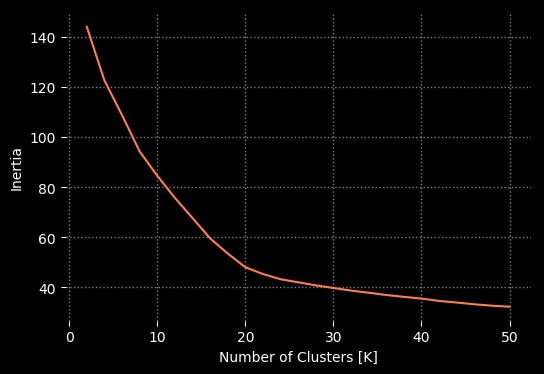

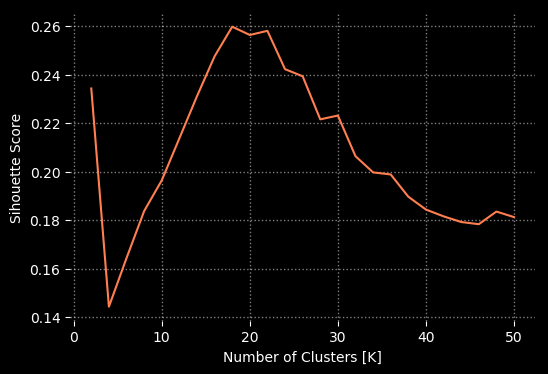

In [332]:
plt.style.use('dark_background')

# plot the inertia scores and look for the kink in the curve
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(n_clusters, inertias, color='coral')
ax.grid(linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Clusters [K]')
ax.set_ylabel('Inertia');
ax.set_frame_on(0)

# plot the silhouettte scores
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(n_clusters, silhouettes, color='coral')
ax.grid(linestyle=':', linewidth=1, alpha=0.5)
ax.set_xlabel('Number of Clusters [K]')
ax.set_ylabel('Sihouette Score');
ax.set_frame_on(0)

In [131]:
seed = 129
kmeans = KMeans(n_clusters=20, init="k-means++", random_state=seed)
kmeans.fit(reduced)
labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))

silhouette = silhouette_score(reduced, 
                              labels, 
                              metric='euclidean', 
                              sample_size=10000, 
                              random_state=seed)
print("Silhouette score: {}".format(silhouette))

Inertia score: 48.07980764298265
Silhouette score: 0.2560227587799726


### TSNE Dimension Reduction and Visualization

In [165]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=seed)
tsne_reduced = tsne.fit_transform(reduced)

In [166]:
tsne_df = pd.DataFrame(tsne_reduced, columns=["tsne_x", "tsne_y"])
tsne_df['Cluster'] = labels

In [167]:
# pickle results
pickle_file = 'APP_tfidf_nmf_tsne_results.pkl'
data = {'tsne': tsne, 
        'tsne_reduced': tsne_reduced,
        'tsne_df': tsne_df}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [168]:
tsne3 = TSNE(n_components=3, perplexity=50, n_iter=500, random_state=seed)
tsne3_reduced = tsne3.fit_transform(reduced)

In [169]:
tsne3_df = pd.DataFrame(tsne3_reduced, columns=["tsne_x", "tsne_y", 'tsne_z'])
tsne3_df['Cluster'] = labels

In [170]:
# pickle results
pickle_file = 'APP_tfidf_nmf_tsne3_results.pkl'
data = {'tsne3': tsne3, 
        'tsne3_reduced': tsne3_reduced,
        'tsne3_df': tsne3_df}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [173]:
groups = tsne_df.groupby('Cluster')

In [174]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = colors.iloc[:, 1]

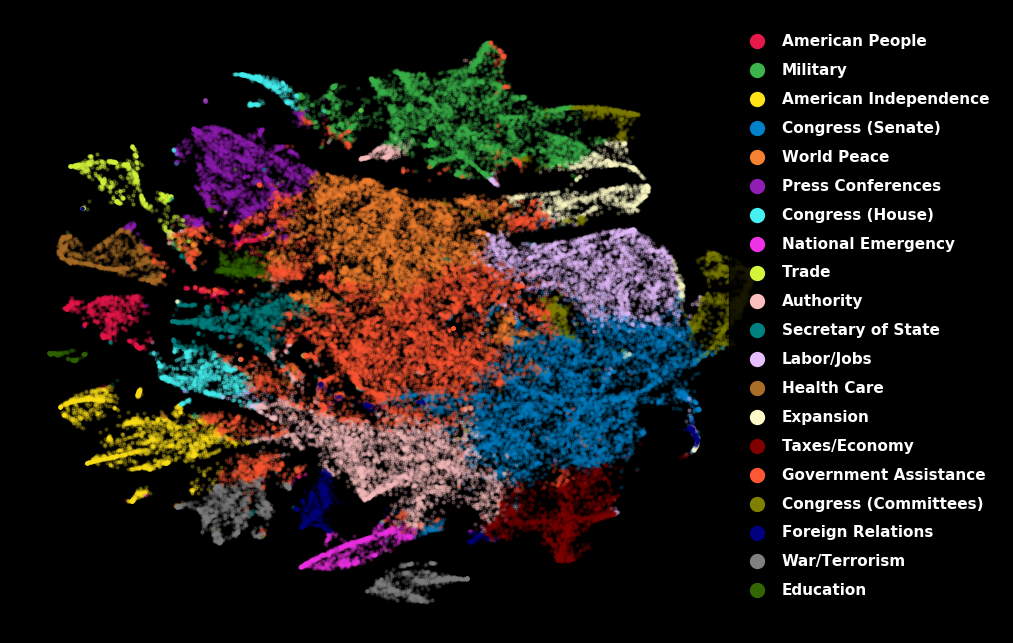

In [224]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))
cidx = 0
for name, group in groups:
    ax.plot(group.tsne_x, group.tsne_y, marker='o', linestyle='', ms=2, alpha=0.2, label=name, color=cmap[cidx])
    cidx += 1
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(0)
ax.set_facecolor('k')
# label_strings = ['Topic #%d' % x for x in set(labels)]
label_strings = topic_list

# leg = ax.legend(loc='upper right')
leg = ax.legend(label_strings, loc=9, bbox_to_anchor=(1.1, 1), 
                labelspacing=1, borderpad=1)
leg.get_frame().set_facecolor('k')
leg.get_frame().set_color('k')
for text in leg.get_texts():
    text.set_color('w')
    text.set_fontsize(11)
    text.set_fontweight('bold')
for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(10)

In [180]:
tsne_reduced.var(0)

array([ 104.37573242,  115.01180267], dtype=float32)